In [92]:
import os
import csv
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

names = [
    ### macro-timestep based algorithms
    "acac", 
    "acac_vanilla",
    "mac_niacc",
    "mac_iaicc",
    ### micro-timestep based algorithms
    "acac_micro", 
    "acac_vanilla_micro",
    "niacc_micro",
    "iaicc_micro",
    "mappo"
    ### ablation study
    # "acac_duplicate",
    # "acac_micro_gae",
    ### additional analysis or ablation study in appendix
    # "acac_eps0.005",
    # "acac_eps0.015",
    # "acac_no_te",
    # "acac_no_sa",
    ]
# benchmarks = ['bp6', 'bp8', 'bp10', 'ovcA7', 'ovcB7', 'ovcC7', 'ovcAR7', 'ovcBR7', 'ovcCR7']
benchmarks = ['ovcA7', 'ovcB7', 'ovcC7', 'ovcAR7', 'ovcBR7', 'ovcCR7']
# benchmarks = ['ovcA11_N6', 'ovcB11_N6', 'ovcC11_N6', 'ovcAR11_N6', 'ovcBR11_N6', 'ovcCR11_N6']

root_dir = '../icml25_result/log'

titles = {
    'bp6': 'BoxPushing-6x6', 'bp8': 'BoxPushing-8x8', 'bp10': 'BoxPushing-10x10',
    'ovcA7': 'Overcooked-A', 'ovcB7': 'Overcooked-B', 'ovcC7': 'Overcooked-C',
    'ovcAR7': 'Overcooked-Rand-A', 'ovcBR7': 'Overcooked-Rand-B', 'ovcCR7': 'Overcooked-Rand-C',
    'ovcA11_N6': 'Overcooked-Large-A', 'ovcB11_N6': 'Overcooked-Large-B', 'ovcC11_N6': 'Overcooked-Large-C',
    'ovcAR11_N6': 'Overcooked-Large-Rand-A', 'ovcBR11_N6': 'Overcooked-Large-Rand-B', 'ovcCR11_N6': 'Overcooked-Large-Rand-C',
}

plot_configs = {
    ### macro-timestep based algorithms
    "acac": {"label": 'ACAC', "color": 'tab:red', "linestyle": '-'}, 
    "acac_vanilla": {"label": 'ACAC-Vanilla', "color": 'tab:cyan', "linestyle": '-'},
    "mac_niacc": {"label": 'Mac-NIACC', "color": 'tab:brown', "linestyle": '-'},
    "mac_iaicc": {"label": 'Mac-IAICC', "color": 'tab:green', "linestyle": '-'},
    ### micro-timestep based algorithms
    "acac_micro": {"label": r'$\mathrm{ACAC}_{\mathrm{micro}}$', "color": 'tab:red', "linestyle": '--'}, 
    "acac_vanilla_micro": {"label": r'$\mathrm{ACAC}$-$\mathrm{Vanilla}_{\mathrm{micro}}$', "color": 'tab:cyan', "linestyle": '--'},
    "niacc_micro": {"label": r'$\mathrm{NIACC}_{\mathrm{micro}}$', "color": 'tab:green', "linestyle": '--'},
    "iaicc_micro": {"label": r'$\mathrm{IAICC}_{\mathrm{micro}}$', "color": 'tab:brown', "linestyle": '--'},
    "mappo": {"label": r'$\mathrm{MAPPO}_{\mathrm{micro}}$', "color": 'tab:olive', "linestyle": '--'},
    ### ablation study
    "acac_duplicate": {"label": 'ACAC-Duplicate', "color": 'tab:purple', "linestyle": '-'},
    "acac_micro_gae": {"label": 'ACAC (micro-level GAE)', "color": 'tab:green', "linestyle": '-'},
    ### additional analysis or ablation study in appendix
    "acac_eps0.005": {"label": r'ACAC ($\varepsilon$=0.005)', "color": 'tab:green', "linestyle": '-'},
    "acac_eps0.015": {"label": r'ACAC ($\varepsilon$=0.015)', "color": 'tab:blue', "linestyle": '-'},
    "acac_no_te": {"label": 'ACAC (No TE)', "color": 'tab:blue', "linestyle": '-'},
    "acac_no_sa": {"label": 'ACAC (No SA)', "color": 'tab:green', "linestyle": '-'},
}

########## ovcA7
../icml25_result/log/ovcA7
2
########## ovcB7
../icml25_result/log/ovcB7
2
########## ovcC7
../icml25_result/log/ovcC7
2
########## ovcAR7
../icml25_result/log/ovcAR7
mac_niacc 0 Not enough timesteps, so copied the last
4
########## ovcBR7
../icml25_result/log/ovcBR7
4
########## ovcCR7
../icml25_result/log/ovcCR7
4
=== Final Performance ===
                   acac     acac_vanilla         mac_niacc         mac_iaicc  \
ovcA7   226.01 \pm 0.38  226.56 \pm 0.04   226.41 \pm 0.15   226.34 \pm 0.08   
ovcB7   226.01 \pm 0.04   225.82 \pm 0.1  157.33 \pm 39.59   226.02 \pm 0.09   
ovcC7   225.72 \pm 0.16  225.36 \pm 0.26    225.38 \pm 0.3   196.47 \pm 26.1   
ovcAR7  223.94 \pm 0.55  225.39 \pm 0.65   202.32 \pm 6.06  190.95 \pm 23.74   
ovcBR7   210.1 \pm 1.57  70.46 \pm 10.49    -5.41 \pm 6.97     4.34 \pm 9.02   
ovcCR7  222.97 \pm 0.65  224.91 \pm 1.35   70.44 \pm 38.31  201.16 \pm 20.02   

             acac_micro acac_vanilla_micro      niacc_micro      iaicc_micro  

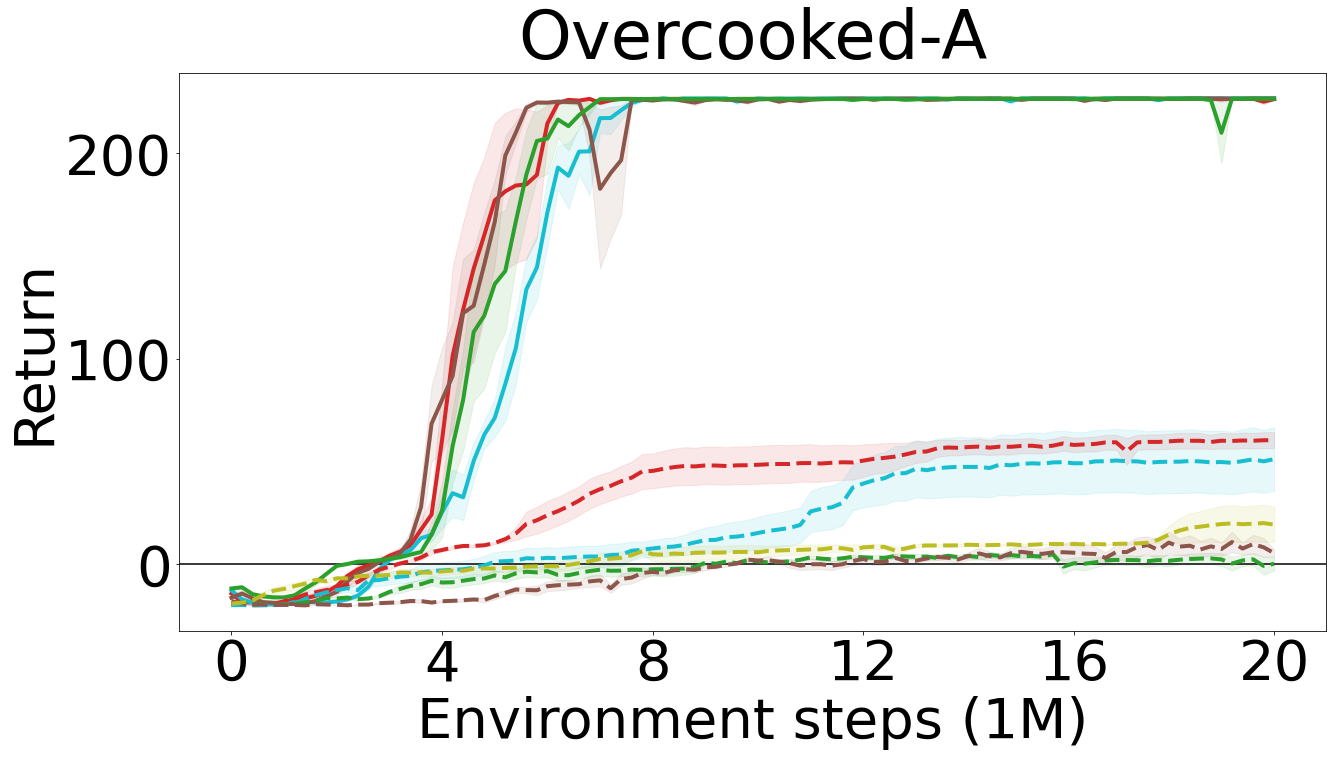

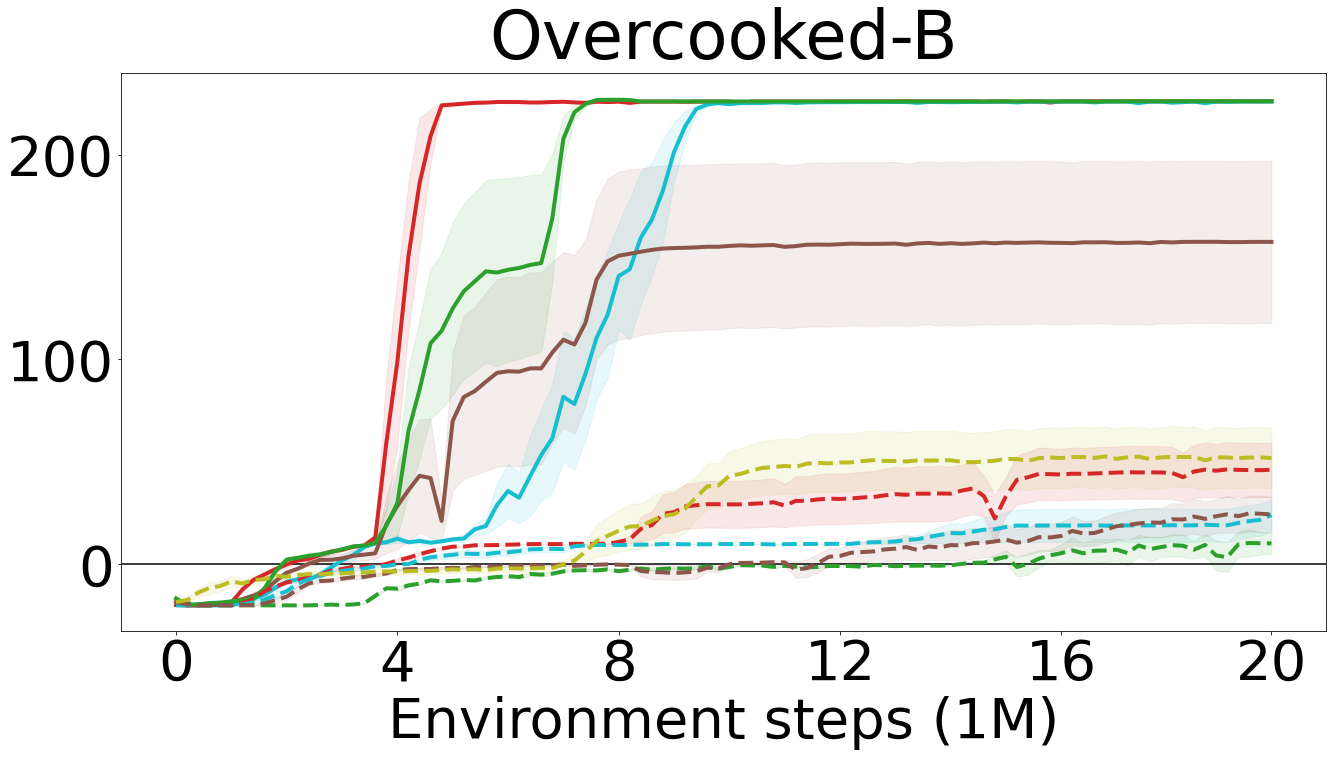

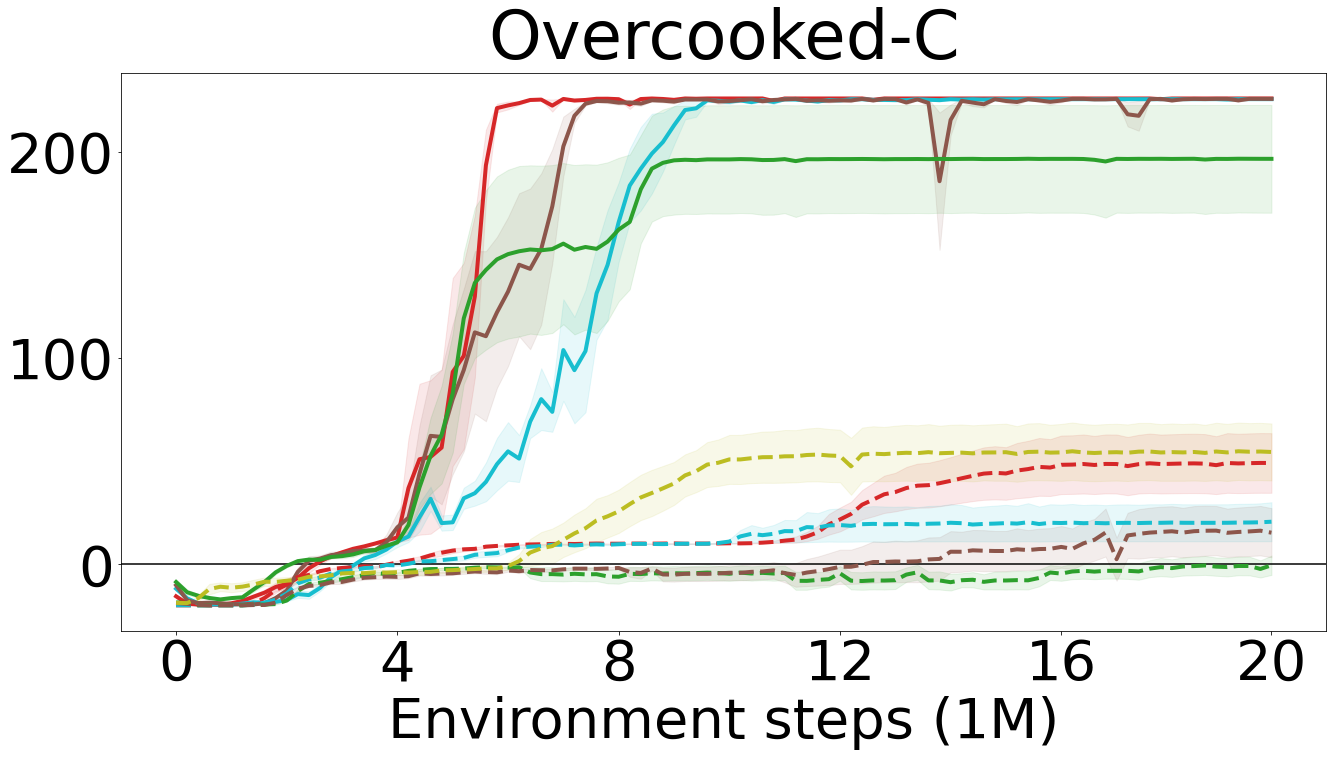

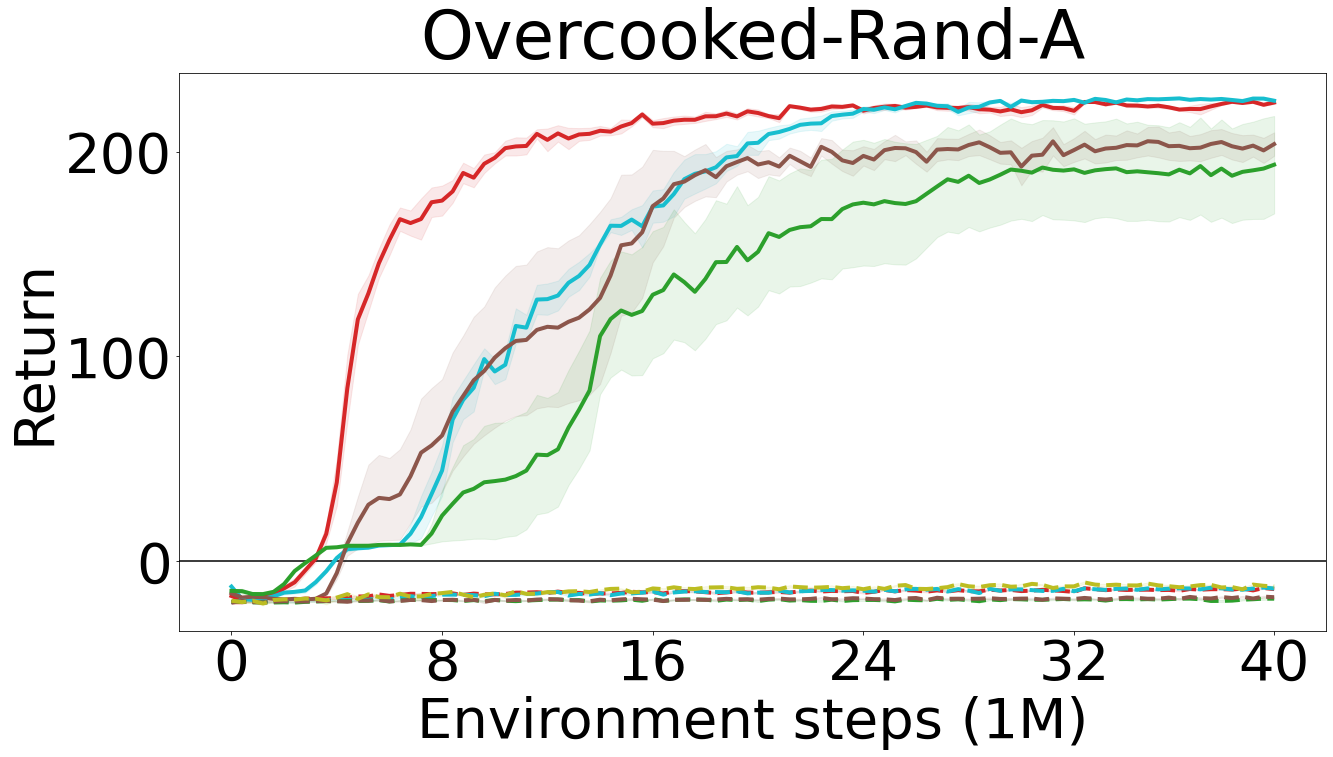

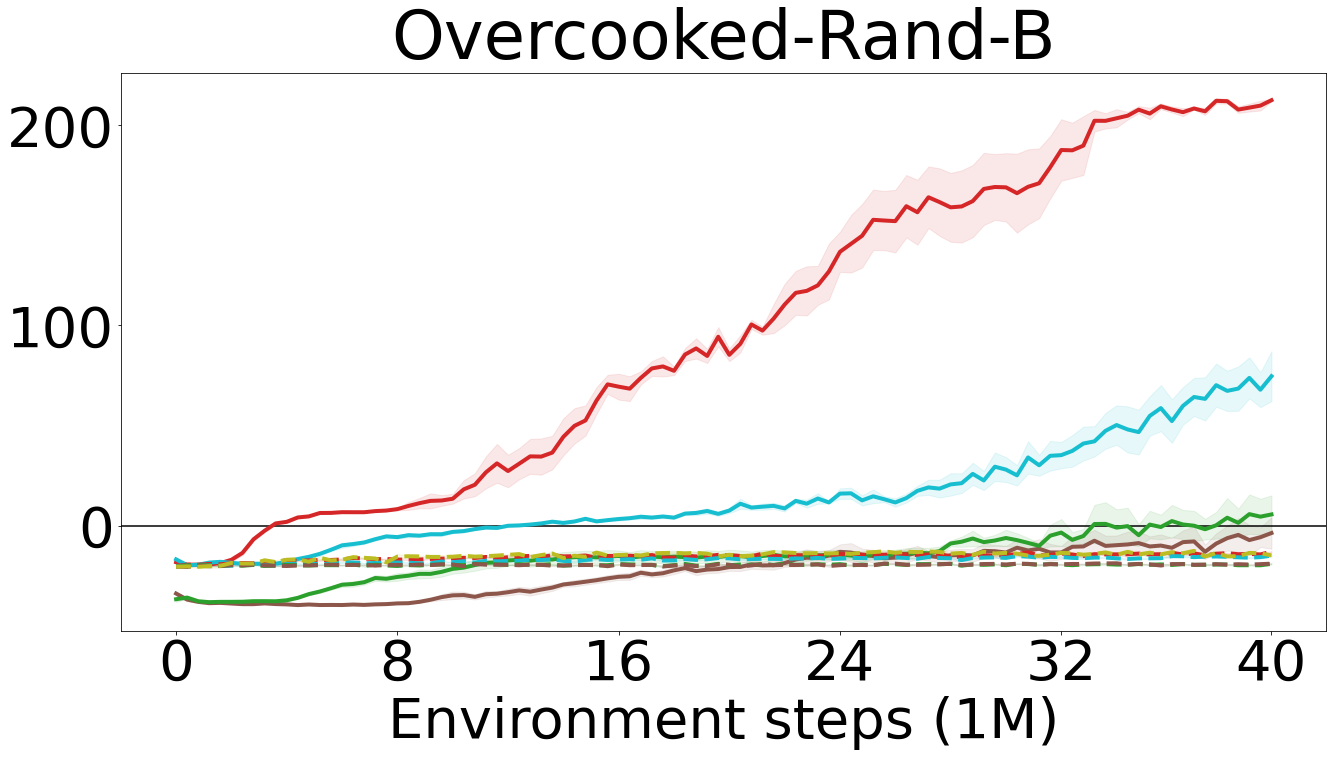

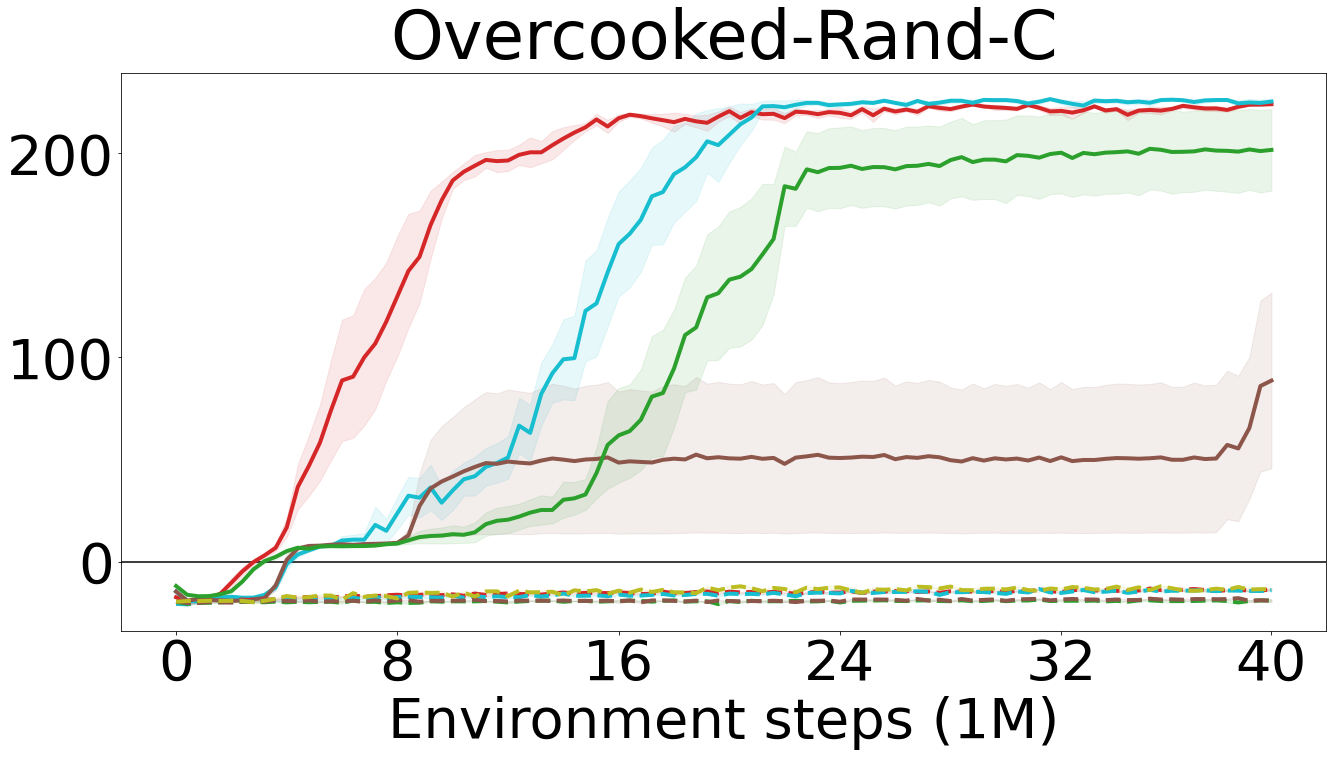

In [93]:
def merge_seeds(data_, num_bucket, bucket_size, name):
    def bucketing(data_, i):
        y = np.zeros(num_bucket)
        cur_bucket = 1
        count = 0
        for row in data_:
            ts, ret = row
            if ts >= total_step:
                break
            if ts < cur_bucket * bucket_size:
                y[cur_bucket-1] += ret
                count += 1
            else:
                y[cur_bucket-1] /= count
                count = 0
                cur_bucket += 1
        if cur_bucket < num_bucket:
            y[cur_bucket-1] /= count
            y[cur_bucket:] = y[cur_bucket-1]
            print(name, i,'Not enough timesteps, so copied the last')
        else:
            assert cur_bucket == num_bucket
            y[cur_bucket-1] /= count
        
        for _i in range(len(y)):
            if 0 < _i < len(y) - 1 and np.isnan(y[_i]):
                y[_i] = (y[_i-1] + y[_i+1]) / 2
        for _i in range(len(y)):
            if _i > 0 and np.isnan(y[_i]):
                y[_i] = y[_i-1]

        return y
    res = []
    for i,data__ in enumerate(data_):
        res.append(bucketing(data__,i))
    y = np.stack(res, axis=1)
    mean = y.mean(axis=1)
    stderr = y.std(axis=1)/np.sqrt(5)
    return y, mean, stderr

def smooth(x,window_len=11,window='flat'):
    if window_len<3:
        return x
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

final_perf = {}
window_size = 2
for bench_i, benchmark in enumerate(benchmarks):
    print('##########', benchmark)
    final_perf[benchmark] = {}
    # LOAD DATA: assume   {model}_{benchmark}_{seed}.csv

    if 'bp' in benchmark:
        total_step = int(int(1e6) *0.5)
        num_bucket = 25
    elif 'ovc' in benchmark:
        if '11' in benchmark:
            total_step = 100 * int(1e6)
        else:
            if 'R' in benchmark:
                total_step = 40 * int(1e6)
            else:
                total_step = 20 * int(1e6)
        num_bucket = 100
    x = np.arange(num_bucket)
    bucket_size = total_step // num_bucket  # 50000


    parent_dir = os.path.join(root_dir, benchmark)
    print(parent_dir)
    if not os.path.exists(parent_dir):
        print(parent_dir + ' not exist')
        continue
    data = dict.fromkeys(names, [])
    for name in names:
        fnames = [os.path.join(parent_dir, f'{name}/{seed}.csv') for seed in range(5)]
        data[name] = []
        for i, fname in enumerate(fnames):
            with open(fname, 'r') as f:
                data[name].append(np.float32([i for i in csv.reader(f)][1:])[...,[0,-1]])

    # PROCESS DATA
    final_data = {}
    for name in data:
        y, mean, stderr = merge_seeds(data[name], num_bucket, bucket_size, name)
        final_data[name+'_mean'] = smooth(mean, window_size)[:-window_size+1 if window_size > 3 else None]
        final_data[name+'_std'] = smooth(stderr, window_size)[:-window_size+1 if window_size > 3 else None]
    data = final_data

    # PLOT
    fig = plt.figure(figsize=(20,12))
    plt.rcParams.update({'font.size':56})
    plt.title(titles[benchmark])

    plt.axhline(y=0, color='black')
    for name in names:
        plt.plot(x, data[f'{name}_mean'],
                 label=plot_configs[name]["label"],
                 color=plot_configs[name]["color"],
                 linestyle=plot_configs[name]["linestyle"],
                 linewidth=4.0
                )
        plt.fill_between(x, data[f'{name}_mean']+data[f'{name}_std'], data[f'{name}_mean']-data[f'{name}_std'], color=plot_configs[name]["color"], alpha=0.1)
        final_perf[benchmark][name] = f"{np.round(np.mean(data[f'{name}_mean'][-5:]), 2)} \pm {np.round(np.mean(data[f'{name}_std'][-5:]), 2)}"
    plt.xlabel("Environment steps (1M)")

    xtick_scale = total_step / 1e7
    if xtick_scale > 1:
        xtick_scale = int(xtick_scale)
    print(xtick_scale)
    plt.xticks([i for i in range(0, num_bucket, num_bucket//5)]+[num_bucket-1], [round(i,1) for i in np.arange(0, 10+1, step=2)*xtick_scale])
    
    if len(benchmarks) >= 2:
        if bench_i % 3 == 0:
            plt.ylabel("Return")
            
    plt.tight_layout()
    plt.savefig(f'../icml25_result/figure/{benchmark}.pdf')


# print final performance
def print_final_perf(final_perf):
    df = pd.DataFrame.from_dict(final_perf, orient='index')

    print('=== Final Performance ===')
    print(df.round(2))

    latex_table = df.to_latex(float_format="%.2f", na_rep="--", index=True)
    print("\n=== LaTeX Table ===")
    print(latex_table)

print_final_perf(final_perf)






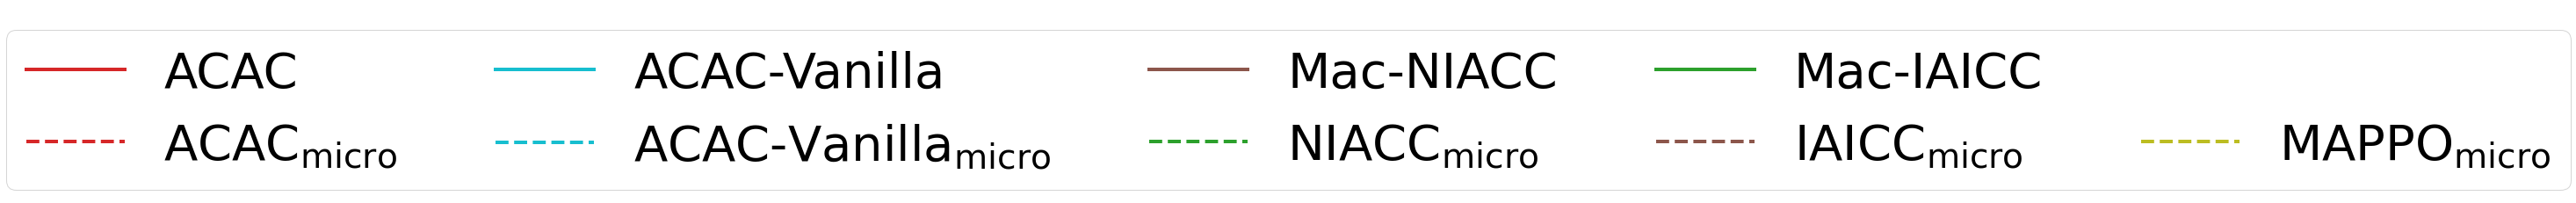

In [94]:
from matplotlib.lines import Line2D
line = Line2D([], [], color='black', linewidth=0, label='')

handles = fig.axes[0].get_legend_handles_labels()
zlines = handles[0][:4] + [line] + handles[0][4:]
zlabels = handles[1][:4] + [''] + handles[1][4:]
llabels=zlabels[::5] + zlabels[1::5] + zlabels[2::5] + zlabels[3::5] + zlabels[4::5]
lzlines = zlines[::5] + zlines[1::5] + zlines[2::5] + zlines[3::5] + zlines[4::5]


fig_leg = plt.figure()
ax_leg = fig_leg.add_subplot(111)


new_handles = (lzlines, llabels)
ax_leg.legend(*new_handles, ncol=5, loc='upper center')
ax_leg.axis('off')
fig_leg.savefig('../icml25_result/figure/main_legend.pdf')